In [2]:
from datetime import date
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, quad


In [3]:
class Covariance:

    def __init__(self, cir_params, neuron_params):
        """ 
        """
        self.cir = cir_params
        self.neuron = neuron_params
        self.neuron['12'] = {
            'omega_prime' : (
                self.neuron['1']['omega_prime'] + self.neuron['2']['omega_prime']
                - self.neuron['1']['omega_prime'] * self.neuron['2']['omega_prime']
            )
        }
        
    def xi(self, process, v):
        return np.sqrt(
            1 + 4 * v * self.cir[process]['sigma'] / self.cir[process]['beta']
        )
    
    def psi(self, xi):
        return (1 + xi) / 2
    
    def zeta(self, process, xi, t):
        return (np.exp(xi * t / self.cir[process]['sigma']) - 1) / xi

    def g(self, process, u, v, t):
        """
        """
        xi = self.xi(process, v)
        psi = self.psi(xi)
        zeta = self.zeta(process, xi, t)

        out = self.cir[process]['beta'] * (
            (u / self.cir[process]['beta'] + psi) * np.exp(xi * t / self.cir[process]['sigma'])
            / (1 + self.cir[process]['sigma'] * (u / self.cir[process]['beta'] + psi) * zeta)
            - psi
        )

        return out
    
    def f(self, process, u, v, t):
        """ 
        """
        xi = self.xi(process, v)
        psi = self.psi(xi)
        zeta = self.zeta(process, xi, t)

        out = (
            np.exp(psi * t / self.cir[process]['sigma']) 
            / (1 + self.cir[process]['sigma'] * (u / self.cir[process]['beta'] + psi) * zeta)
        )

        return out

    def g_k(self, process, t_previous, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).
        """
        
        u, v, t = args[0]

        if len(args) == 1:
            # Base case (should be highest value of k for G_{k+1}).
            out = self.g(process, u, v, t - t_previous)
        else:
            out = self.g(process, u + self.g_k(process, t, *args[1:]), v, t - t_previous)

        return out

    def g_n_minus_k(self, process, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).

        # Iterative, cached solution possible here. Avoids repeat computations.
        """
        n = len(args)
        all_g = np.full((n,), np.nan)
        
        # # Precompute n_th term.
        # if n == 1:
        #     # If there is only one term, t1 - 0 = t1.
        #     all_g[-1] = self.g(*args[-1])
        # else:
        #     all_g[-1] = self.g(args[-1][0], args[-1][1], args[-1][2] - args[-2][2])

        # Go in reverse order for remaining elements (beginning from n, ending 
        # with item 2 (corresponding to k+1 when k=1)).
        for i_arg, arg in reversed(list(enumerate(args))[1:]):
            u, v, t = arg

            t_previous = args[i_arg-1][2]
            
            # Handle innermost term edge case.
            if i_arg == n - 1:
                all_g[i_arg] = self.g(process, u, v, t - t_previous)
            else:
                all_g[i_arg] = self.g(process, u + all_g[i_arg + 1], v, t - t_previous)

        all_g = np.concatenate((all_g[1:], np.array([0]))) # initially, i_arg = k, and G_0 = 0, thus need to remove first element

        return all_g
    
    def f_k(self, process, *args):
        """ 
        """
        
        n = len(args)
        
        # all_g_n_minus_k = np.concatenate((self.g_n_minus_k(process, *args[1:]), np.array([0.])))
        all_g_n_minus_k = self.g_n_minus_k(process, *args)
        all_f_k = np.full((n,), np.nan)
        for i_arg in range(n):
            t_previous = 0 if i_arg == 0 else args[i_arg-1][2]
            u, v, t = args[i_arg]
            all_f_k[i_arg] = self.f(process, u + all_g_n_minus_k[i_arg], v, t - t_previous)

        return all_f_k

    def cir_expectation(self, process, *args):
        """
        *args should be a sequence of positional arguments x_1, x_2, x_3, ... x_n, 
        where each x_i is a triple (tuple) consisting of (u_i, v_i, t_i).

        """
        g_n = self.g_k(process, 0, *args)
        all_f_k = self.f_k(process, *args)

        final = (
            np.prod(all_f_k) / (1 + g_n / self.cir[process]['beta'])
        )**self.cir[process]['alpha']

        return final

        # for k in range(n):
        #     u, v, t = args[k]

        #     j = n - k - 1 # Idx for g_n_k

        #     all_f[k] = self.f(u + g_n_k[j], v, t)

    def covariance_kernel(self, s1, s2, t1, t2):
        """ 
        """
        expectation1 = self.cir_expectation(
            '1', (0, 0, s1), (0, self.neuron['1']['omega'], t1)
        )
        
        expectation2 = self.cir_expectation(
            '2', (0, 0, s2), (0, self.neuron['2']['omega'], t2)
        ) #TODO: Check if arguments are really the same
        
        upsilon = (
            self.cir_expectation(
                '12',
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], t2)
            )
            *
            self.cir_expectation(
                '12',
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], t1)
            )
        )
        if s2 >= t1:
            delta_epsilon12 = self.cir_expectation(
                '12', 
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], t1),
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        elif s1 <= s2 and s2 < t1:
            delta_epsilon12 = self.cir_expectation(
                '12', 
                (0, 0, s1),
                (0, self.neuron['1']['omega_prime'], s2),
                (0, self.neuron['12']['omega_prime'], t1),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        elif s2 <= s1 < t1:
            delta_epsilon12 = self.cir_expectation(
                '12',
                (0, 0, s2),
                (0, self.neuron['2']['omega_prime'], s1),
                (0, self.neuron['12']['omega_prime'], t1),
                (0, self.neuron['2']['omega_prime'], t2)
            ) - upsilon
        else:
            raise RuntimeError("Unimplemented condition.")

        covariance = expectation1 * expectation2 * delta_epsilon12
        
        return covariance, expectation1, expectation2, delta_epsilon12
    
    # def du_ds(self, neuron_, t, s):
    #     """ 
    #     e.g. neuron_ = '1'
    #     """
    #     if s >= 0:
    #         du_ds = (
    #             self.neuron[neuron_]['v_e'] * (1/self.neuron[neuron_]['tau']) 
    #             * np.exp((s - t)/self.neuron[neuron_]['tau'])
    #         )
    #         # upsilon = self.neuron[neuron_]['v_e'] - self.neuron[neuron_]['v_0']
    #     else:
    #         du_ds = (
    #             (2*(self.neuron[neuron_]['v_e']) - self.neuron[neuron_]['v_0'])
    #             * (1/self.neuron[neuron_]['tau']) 
    #             * np.exp((s - t)/self.neuron[neuron_]['tau'])
    #         )
    #     return du_ds

    def u_measure(self, neuron_, t, s):
        """ 
        e.g. neuron_ = '1'
        """
        # if s == 0:
        #     a = (
        #         np.exp(-t / self.neuron[neuron_]['tau'])
        #         * (self.neuron[neuron_]['v_e'] - self.neuron[neuron_]['v_0'])
        #     )
        # else:
        #     a = 0
        # out = (
        #     np.exp((s-t) / self.neuron[neuron_]['tau']) 
        #     * self.neuron[neuron_]['v_e'] 
        #     / self.neuron[neuron_]['tau']
        #     + a
        # )
        # return out
        indicator = 1 if s >= 0 else 0
        out = (
            np.exp((s-t) / self.neuron[neuron_]['tau']) 
            * (
                self.neuron[neuron_]['v_e'] 
                + (self.neuron[neuron_]['v_e'] - self.neuron[neuron_]['v_0']) * indicator
            )
        )
        return out
    
    def covariance_integrand(self, s1, s2, t1, t2):
        """ 
        """
        kernel, _, _, _ = self.covariance_kernel(s1, s2, t1, t2) 
        return (
            kernel * self.u_measure('1', t1, s1) * self.u_measure('2', t2, s2)
        )
    
    def compute_covariance(self, t1, t2):
        """ 
        """
        val, err = dblquad(self.covariance_integrand, 0, t2, 0, t1, args=(t1, t2))
        return val, err




        

In [28]:
cir_params = {
    '1' : {
        'rate' : 4,
        'sigma' : 1, # sigma in Thibaud's notes, this is tau for the CIR process in mine
        'beta' : 0.5,
    },
    '2' : {
        'rate' : 4,
        'sigma' : 1, 
        'beta' : 0.5,
    },
    '12' : {
        'rate' : 4,
        'sigma' : 1, 
        'beta' : 0.5,
    }
}

for key in cir_params.keys():
    cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

neuron_params = {
    '1' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 0.02,
        'v_e' : 70,
        'v_0' : 0
    },
    '2' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 0.02,
        'v_e' : 70,
        'v_0' : 0
    }
}




covariance = Covariance(cir_params, neuron_params)



# cir_params = {
#     '1' : {
#         'rate' : 1,
#         'sigma' : 1, 
#         'beta' : 1,
#     },
#     '2' : {
#         'rate' : 1,
#         'sigma' : 1, 
#         'beta' : 1,
#     },
#     '12' : {
#         'rate' : 1,
#         'sigma' : 1, 
#         'beta' : 1,
#     }
# }

# for key in cir_params.keys():
#     cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

# neuron_params = {
#     '1' : {
#         'omega' : 0,
#         'omega_prime' : 0,
#         'tau' : 1,
#         'v_e' : 70,
#         'v_0' : 0
#     },
#     '2' : {
#         'omega' : 0,
#         'omega_prime' : 0,
#         'tau' : 1,
#         'v_e' : 70,
#         'v_0' : 0
#     }
# }




# covariance = Covariance(cir_params, neuron_params)



0
1
2
3
4
5
6
7
8
9
[0.4234414  0.4234414  0.4234414  0.42344139 0.4228684  0.01153123
 0.00898772 0.00719088 0.00575422 0.0046052 ]


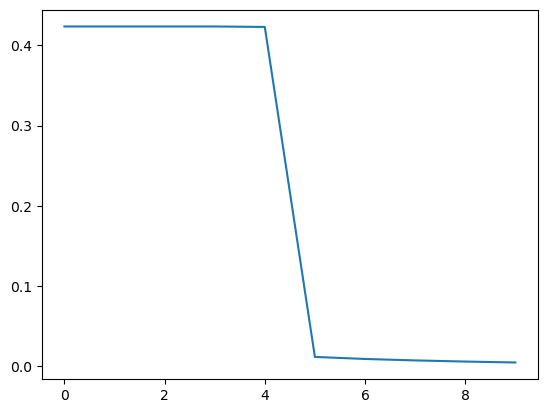

In [ ]:
steps = np.linspace(-1, 1, 10)

cov = np.full((len(steps),), fill_value=np.nan)
err = np.full((len(steps),), fill_value=np.nan)
for i_step, step in enumerate(steps):
    print(i_step)
    cov[i_step], err[i_step] = covariance.compute_covariance(5 + step, 5)
print(cov)
plt.plot(cov)


In [21]:
# Test expectation for recovery of known cases e.g. when setting parameters to 0.
# Plot delta_12. t1 = t2, varying s2? 

def single_v_t_expectation(covariance, v, t_0, t_n):
    xi =  covariance.xi('1', v)
    sigma = covariance.cir['1']['sigma']
    
    numerator = 4 * xi * np.exp((1 + xi)*(t_n - t_0)/(2*sigma))
    denominator = (1 + xi)**2 * np.exp(xi * (t_n - t_0) / (sigma)) - (1 - xi)**2

    out = (numerator / denominator) ** covariance.cir['1']['alpha']

    return out, xi, sigma


v = 1
t_0 = 0
t_n = 7.1
x_1 = (0, v, 1)
x_2 = (0, v, 3)
x_3 = (0, v, 4)
x_4 = (0, v, 5)
x_5 = (0, v, t_n)

z1 = covariance.cir_expectation('1', x_1, x_2, x_3, x_4, x_5)
z2, xi, sigma = single_v_t_expectation(covariance, v, t_0, t_n)

print(z1, z2)
print(f"xi: {xi}, sigma: {sigma}")



3.8294895070622635e-07 3.829489507062274e-07
xi: 3.0, sigma: 1


In [22]:
# To get interactive plots, do the following: install ipympl package and
# restart VS code. Then, run either %matplotlib widget or %matplotlib ipympl in 
# the notebook.
%matplotlib widget

covariance_kernel
[[1.55315449e-04 1.54431591e-04 1.53489634e-04 ... 8.99318936e-06
  7.61560874e-06 6.27259074e-06]
 [1.54431591e-04 1.53933113e-04 1.53046662e-04 ... 9.00004995e-06
  7.62141937e-06 6.27737736e-06]
 [1.53489634e-04 1.53046662e-04 1.52546181e-04 ... 9.00691251e-06
  7.62723177e-06 6.28216552e-06]
 ...
 [8.99318936e-06 9.00004995e-06 9.00691251e-06 ... 5.77031211e-06
  5.00141258e-06 4.20512063e-06]
 [7.61560874e-06 7.62141937e-06 7.62723177e-06 ... 5.00141258e-06
  4.68115639e-06 3.95008334e-06]
 [6.27259074e-06 6.27737736e-06 6.28216552e-06 ... 4.20512063e-06
  3.95008334e-06 3.66851264e-06]]
delta_12
[[1.68227076e-04 1.67205678e-04 1.66122155e-04 ... 9.38546246e-06
  7.94474609e-06 6.54117536e-06]
 [1.67205678e-04 1.66602134e-04 1.65579285e-04 ... 9.38902492e-06
  7.94776268e-06 6.54365976e-06]
 [1.66122155e-04 1.65579285e-04 1.64974611e-04 ... 9.39258534e-06
  7.95077764e-06 6.54614289e-06]
 ...
 [9.38546246e-06 9.38902492e-06 9.39258534e-06 ... 5.80232353e-06
  5.0

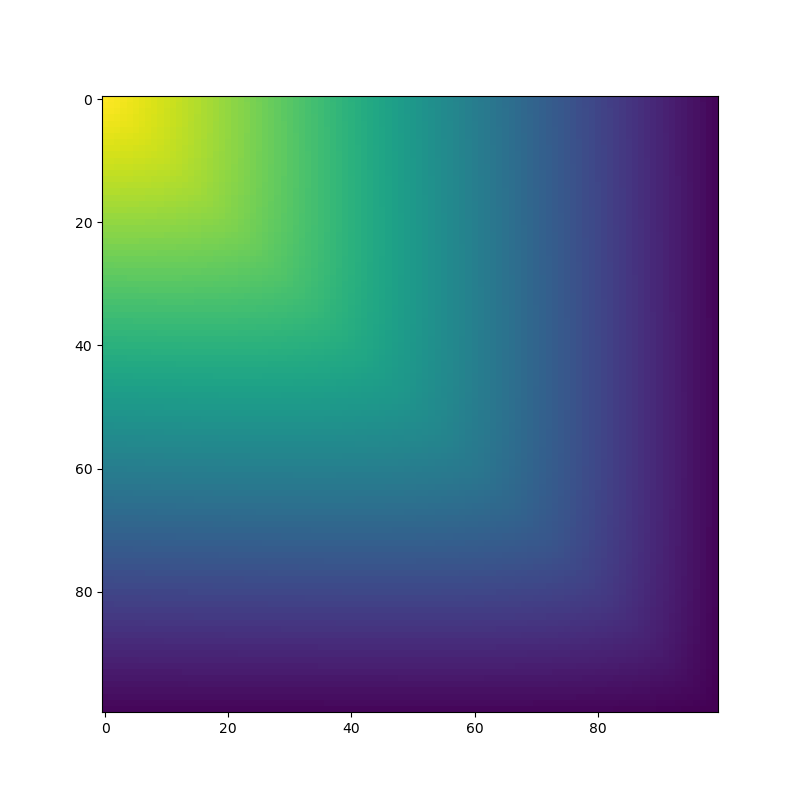

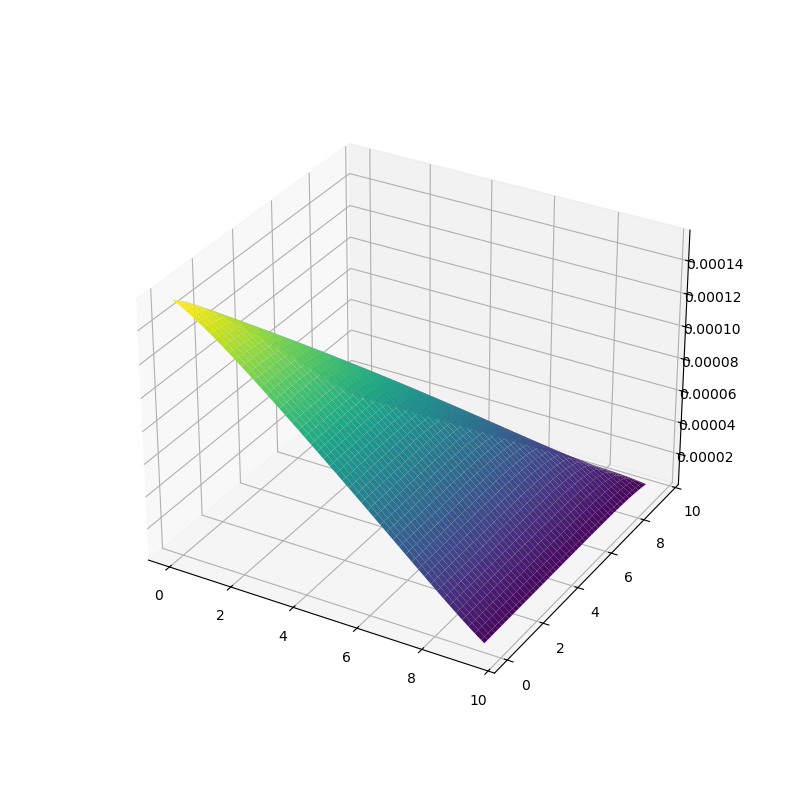

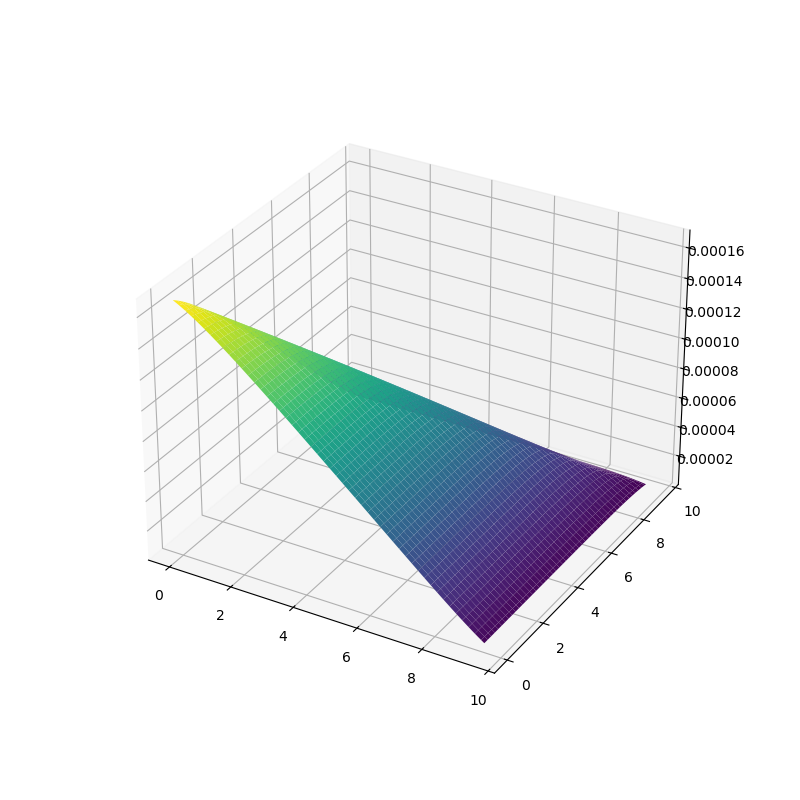

In [23]:
# Plot covariance kernel.
t1 = 10
t2 = t1

num_steps = 100
s_start = 0
s_end = t1 - 0.5
s1_all = np.linspace(s_start, s_end, num_steps)
s2_all = s1_all.copy()

cov_all = np.full((num_steps, num_steps), np.nan)
delta_12_all = np.full(cov_all.shape, np.nan)
for i_s2, s2 in enumerate(s2_all): 
    for i_s1, s1 in enumerate(s1_all):
        cov_all[i_s2, i_s1], _, _, delta_12_all[i_s2, i_s1] = covariance.covariance_kernel(s1, s2, t1, t2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)
ax1.imshow(cov_all)

x_vals, y_vals = np.meshgrid(s1_all, s2_all)
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(x_vals, y_vals, cov_all, linewidth=0, cmap='viridis')
# ax.set_xlabel('s_1')

print("covariance_kernel")
print(cov_all)

fig3 = plt.figure(figsize=(8,8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(x_vals, y_vals, delta_12_all, linewidth=0, cmap='viridis')

print("delta_12")
print(delta_12_all)



In [11]:
out1a = covariance.covariance_kernel(s1_all[24], s2_all[22], t1, t2)
print(out1a)

out1b = covariance.covariance_kernel(s2_all[22], s1_all[24], t1, t2)
print(out1b)


# out2a = covariance.covariance_kernel(s1_all[24], s2_all[21], t1, t2)
# print(out2a)

# out2b = covariance.covariance_kernel(s2_all[21], s1_all[24], t1, t2)
# print(out2b)



(np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0))
(np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0))


In [12]:
# Ensure that G1 and G2 in the covariance kernel C in 1.3.1 match the values 
# computed by evaluating the expectation for a single set of parameters (v, t) 
# with t = t1-s1.

s1 = 10
t1 = 10

out1, _, _ = single_v_t_expectation(covariance, covariance.neuron['1']['omega'], s1, t1)
out2 = covariance.cir_expectation(
            '1', (0, 0, s1), (0, covariance.neuron['1']['omega'], t1) 
        )

print(out1, out2)
print(covariance.neuron['1']['omega'])

1.0 1.0
0


In [6]:
# Check that we recover the deterministic rate case, for fixed r, in the limit 
# of large beta or small sigma.

cir_params = {
    '1' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '2' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 1,
    },
    '12' : {
        'rate' : 1,
        'sigma' : 1, 
        'beta' : 10,
    }
}

for key in cir_params.keys():
    cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

neuron_params = {
    '1' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    },
    '2' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 1,
        'v_e' : 70,
        'v_0' : 0
    }
}

covariance = Covariance(cir_params, neuron_params)

s1 = 0.3
s2 = 8.1
t1 = 10
t2 = t1


def large_beta(covariance, s1, s2, t):
    out = (
        np.exp(
            -covariance.neuron['1']['omega_prime'] * covariance.cir['12']['rate'] * (t - s1)
            -covariance.neuron['2']['omega_prime'] * covariance.cir['12']['rate'] * (t - s2)
        )
        *
        (
            np.exp(
                covariance.neuron['1']['omega_prime']
                * covariance.neuron['2']['omega_prime']
                * covariance.cir['12']['rate']
                * (t - np.max(np.array([s1, s2])))
            )
            - 1
        )
    )
    return out


kernel, _, _, delta_12 = covariance.covariance_kernel(s1, s2, t1, t2)
delta_12_ = large_beta(covariance, s1, s2, t1)

print(delta_12, delta_12_)
print(delta_12 - delta_12_)



0.00010765470323635201 5.2117407316974524e-05
5.553729591937749e-05


In [13]:
cir_params = {
    '1' : {
        'rate' : 4,
        'sigma' : 1, # sigma in Thibaud's notes, this is tau for the CIR process in mine
        'beta' : 0.5,
    },
    '2' : {
        'rate' : 4,
        'sigma' : 1, 
        'beta' : 0.5,
    },
    '12' : {
        'rate' : 4,
        'sigma' : 1, 
        'beta' : 0.5,
    }
}

for key in cir_params.keys():
    cir_params[key]['alpha'] = cir_params[key]['rate']*cir_params[key]['beta']

neuron_params = {
    '1' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 0.02,
        'v_e' : 70,
        'v_0' : 0
    },
    '2' : {
        'omega' : 1,
        'omega_prime' : 1,
        'tau' : 0.02,
        'v_e' : 70,
        'v_0' : 0
    }
}

covariance = Covariance(cir_params, neuron_params)


def single_v_t_expectation(covariance, v, t_0, t_n):
    xi =  covariance.xi('1', v)
    sigma = covariance.cir['1']['sigma']
    
    numerator = 4 * xi * np.exp((1 + xi)*(t_n - t_0)/(2*sigma))
    denominator = (1 + xi)**2 * np.exp(xi * (t_n - t_0) / (sigma)) - (1 - xi)**2

    out = (numerator / denominator) ** covariance.cir['1']['alpha']

    return out, xi, sigma

single_v_t_expectation()


TypeError: single_v_t_expectation() missing 4 required positional arguments: 'covariance', 'v', 't_0', and 't_n'

In [31]:
cir_params = {
    'rate' : 4,
    'sigma' : 0.1, # sigma in Thibaud's notes, this is tau for the CIR process in mine
    'beta' : 0.5
}
cir_params['alpha'] = cir_params['rate']*cir_params['beta']

neuron_params = {
    'omega' : 0.5, # private input strength
    'omega_prime' : 0.5, # shared input strength
    'tau' : 0.02,
    'v_e' : 70,
    'v_0' : 0
}

def xi(x, cir_params):
    return np.sqrt(1 + (4*cir_params['sigma']*x/cir_params['beta']))

def omega(s, t, cir_params, neuron_params):
    xi_= xi(neuron_params['omega'], cir_params) # omega = k * \tilde{w_e}, i.e. excitatory synaptic strength scaled by number of excitatory inputs
    numerator = 4 * xi_ * np.exp((1 + xi_)*(t-s)/(2*cir_params['sigma']))
    denominator = (1 + xi_)**2 * np.exp(xi_ * (t-s) / (cir_params['sigma'])) - (1 - xi_)**2

    return (numerator / denominator) ** cir_params['alpha']

def integrand(s, t, cir_params, neuron_params):
    return np.exp(-(t-s)/neuron_params['tau']) * omega(s, t, cir_params, neuron_params)

def expected_voltage(cir_params, neuron_params, t_max):
    omega_ = omega(0, t_max, cir_params, neuron_params)
    integral, error_estimate = quad(integrand, 0, t_max, args=(t_max, cir_params, neuron_params))
    
    ev = (
        neuron_params['v_0'] * np.exp(-t_max/neuron_params['tau']) * omega_
        + neuron_params['v_e'] * (1 - np.exp(-t_max/neuron_params['tau']) * omega_)
        - (neuron_params['v_e']/neuron_params['tau']) * integral
    )

    return ev, error_estimate

ev, error_estimate = expected_voltage(cir_params, neuron_params, t_max=50)
print(ev, error_estimate)

2.651783926501551 4.502070325644158e-09


In [32]:
cir_params['alpha']

2.0

In [33]:
sweep = {
    'alpha' : np.linspace(start=2, stop=5, num=10),
    'beta' : np.linspace(start=0.25, stop=5, num=10),
    'tau': (1, 3, 5, 10),
    'save': False,
    'save_dir': '/home/jonathan/projects/membrane_voltage/results/',
    'date': date.today(),
    'run_id': '0000'
}
cir_params_to_vary = list(
    itertools.product(
        sweep['alpha'], sweep['beta'], sweep['tau']
    )
)
num_param_sets = len(cir_params_to_vary)

# Compute rates.
expected_values = np.empty((num_param_sets,))
error_estimate = np.empty((num_param_sets,))
for i_parameter_set, parameters in enumerate(cir_params_to_vary):
    alpha, beta, tau = parameters
    cir_params['rate'] = alpha / beta
    cir_params['alpha'] = alpha
    cir_params['beta'] = beta
    cir_params['sigma'] = tau
    # print(alpha, beta, tau)

    expected_values[i_parameter_set], error_estimate[i_parameter_set] = expected_voltage(
        cir_params, neuron_params, t_max=50
    )
    print(i_parameter_set)
    print(alpha, beta, tau)
    print(cir_params.items())
    print(expected_values[i_parameter_set])






0
2.0 0.25 1
dict_items([('rate', np.float64(8.0)), ('sigma', 1), ('beta', np.float64(0.25)), ('alpha', np.float64(2.0))])
5.020968365514136
1
2.0 0.25 3
dict_items([('rate', np.float64(8.0)), ('sigma', 3), ('beta', np.float64(0.25)), ('alpha', np.float64(2.0))])
5.019050635175105
2
2.0 0.25 5
dict_items([('rate', np.float64(8.0)), ('sigma', 5), ('beta', np.float64(0.25)), ('alpha', np.float64(2.0))])
5.018661572177592
3
2.0 0.25 10
dict_items([('rate', np.float64(8.0)), ('sigma', 10), ('beta', np.float64(0.25)), ('alpha', np.float64(2.0))])
5.018368547650553
4
2.0 0.7777777777777778 1
dict_items([('rate', np.float64(2.571428571428571)), ('sigma', 1), ('beta', np.float64(0.7777777777777778)), ('alpha', np.float64(2.0))])
1.7343208436207078
5
2.0 0.7777777777777778 3
dict_items([('rate', np.float64(2.571428571428571)), ('sigma', 3), ('beta', np.float64(0.7777777777777778)), ('alpha', np.float64(2.0))])
1.7340611129349242
6
2.0 0.7777777777777778 5
dict_items([('rate', np.float64(2.57142

In [34]:
print(expected_values.shape)

expected_values_reshaped = np.reshape(expected_values, shape=(len(sweep['alpha']), len(sweep['beta']), len(sweep['tau'])))
print(expected_values_reshaped)
print(expected_values_reshaped.shape)

(400,)
[[[ 5.02096837  5.01905064  5.01866157  5.01836855]
  [ 1.73432084  1.73406111  1.73400837  1.73396864]
  [ 1.0485741   1.04847648  1.04845665  1.04844171]
  [ 0.75148257  0.75143181  0.7514215   0.75141373]
  [ 0.58557919  0.58554815  0.58554185  0.5855371 ]
  [ 0.47968292  0.479662    0.47965776  0.47965455]
  [ 0.40622247  0.40620743  0.40620437  0.40620207]
  [ 0.35227427  0.35226293  0.35226062  0.35225889]
  [ 0.3109755   0.31096665  0.31096485  0.31096349]
  [ 0.27834403  0.27833693  0.27833549  0.2783344 ]]

 [[ 5.79058538  5.78844466  5.7880104   5.78768335]
  [ 2.01514625  2.01484802  2.01478747  2.01474185]
  [ 1.22031094  1.22019815  1.22017524  1.22015798]
  [ 0.87517163  0.87511282  0.87510088  0.87509188]
  [ 0.68222827  0.68219227  0.68218495  0.68217944]
  [ 0.55899371  0.55896942  0.55896448  0.55896077]
  [ 0.47346954  0.47345205  0.4734485   0.47344582]
  [ 0.41064304  0.41062986  0.41062718  0.41062516]
  [ 0.36253689  0.36252659  0.3625245   0.36252292]
  [

0 2 1
[2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.         4.33333333 4.66666667 5.        ]
[0.25       0.77777778 1.30555556 1.83333333 2.36111111 2.88888889
 3.41666667 3.94444444 4.47222222 5.        ]
(1, 3, 5, 10)
[5.02096837 1.73432084 1.0485741  0.75148257 0.58557919 0.47968292
 0.40622247 0.35227427 0.3109755  0.27834403]
[5.01905064 1.73406111 1.04847648 0.75143181 0.58554815 0.479662
 0.40620743 0.35226293 0.31096665 0.27833693]
[5.01866157 1.73400837 1.04845665 0.7514215  0.58554185 0.47965776
 0.40620437 0.35226062 0.31096485 0.27833549]
[5.01836855 1.73396864 1.04844171 0.75141373 0.5855371  0.47965455
 0.40620207 0.35225889 0.31096349 0.2783344 ]
0 2 1
[2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.         4.33333333 4.66666667 5.        ]
[0.25       0.77777778 1.30555556 1.83333333 2.36111111 2.88888889
 3.41666667 3.94444444 4.47222222 5.        ]
(1, 3, 5, 10)
[5.79058538 2.01514625 1.22031094 0.87517163 0.68222827 0.

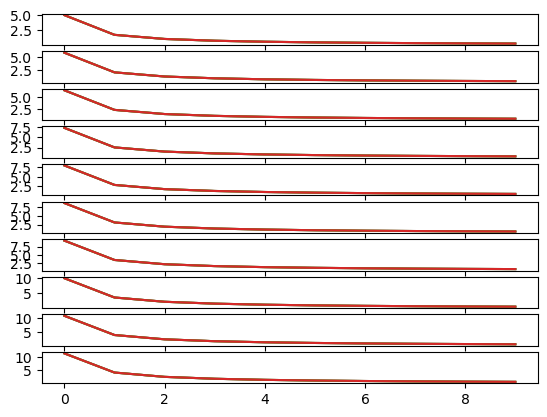

In [35]:
FOR_EACH = 'alpha'
PLOT_ACROSS = 'beta'
WITH_REMAINING = 'tau'

def get_idx(param_name):
    return 0 if param_name == 'alpha' else 1 if param_name == 'beta' else 2

for_each = sweep[FOR_EACH]
idx_for_each = get_idx(FOR_EACH)
plot_across = sweep[PLOT_ACROSS]
idx_plot_across = get_idx(PLOT_ACROSS)
with_remaining = sweep[WITH_REMAINING]
idx_with_remaining = get_idx(WITH_REMAINING)

fig_10, axs_10 = plt.subplots(len(for_each), 1, squeeze=False)


for i_row, val in enumerate(for_each):
    
    print(idx_for_each, idx_with_remaining, idx_plot_across)
    print(for_each)
    print(plot_across)
    print(with_remaining)
    expected_values_reshaped_perm = np.permute_dims(expected_values_reshaped, axes=(idx_for_each, idx_with_remaining, idx_plot_across))
    for i_remaining in range(len(with_remaining)):
        axs_10[i_row, 0].plot(np.array(range(len(plot_across))), expected_values_reshaped_perm[i_row, i_remaining, :])
        print(expected_values_reshaped_perm[i_row, i_remaining, :])